# ML Zoomcamp 2023 – Second Capstone Project

[Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs)

In [1]:
import os
import re
import subprocess
from pathlib import Path
from time import time
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
p1 = subprocess.run('python -m pip install scikit-image -q', shell=True,
                    check=True, capture_output=True, text=True)
from skimage.io import imread
from skimage.transform import resize
if p1.stderr:
    print(p1.stderr)

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img

In [4]:
images_dir = 'data/raw/Images'
annotation_dir = 'data/raw/Annotation'
processed_dir = 'data/processed'
img_size = 299

## Data preparation

In [5]:
select_breed_dir_list = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound',
                         'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed',
                         'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees',
                         'n02111129-Leonberg']

In [11]:
# modified from https://www.kaggle.com/code/hengzheng/dog-breeds-classifier/notebook
breed_dir_list = [name for name in select_breed_dir_list if name not in ['.DS_Store']]
if not Path(processed_dir).exists():
    Path.mkdir(Path.cwd() / processed_dir, exist_ok=True)
    for breed_dir in breed_dir_list:
        breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
        breed_name = re.sub(r'-', r'_', breed_name.lower())
        Path.mkdir(Path.cwd() / processed_dir / breed_name, exist_ok=True)
    print(f'''Created {len(os.listdir(processed_dir))} folders to store cropped images of the different breeds.''')
else:
    print(f'Folder {processed_dir} already exists.')

Created 10 folders to store cropped images of the different breeds.


In [12]:
t0 = time()
print(f'Saving {img_size}x{img_size} image sizes.')
if not list(Path(processed_dir).glob('**/*.jpg')):
    for breed_dir in breed_dir_list:
        counter = 0
        for breed_prefix in os.listdir(f'{annotation_dir}/{breed_dir}'):
            img = Image.open(f'{images_dir}/{breed_dir}/{breed_prefix}.jpg')
            tree = ET.parse(f'{annotation_dir}/{breed_dir}/{breed_prefix}')
            xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
            xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
            ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
            ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
            img = img.crop((xmin, ymin, xmax, ymax))
            img = img.convert('RGB')
            img = img.resize((img_size, img_size))
            breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
            breed_name = re.sub(r'-', r'_', breed_name.lower())
            img.save(processed_dir + '/' + breed_name + '/' + breed_prefix + '.jpg')
            counter += 1
        print(f'Saved {counter} images in {breed_name} folder.')
    print(f'Time elapsed: {round(time()-t0, 0)} seconds.')
else:
    print(f'Folder {processed_dir} with cropped images already exists.')

Saving 299x299 image sizes.
Saved 252 images in maltese_dog folder.
Saved 239 images in afghan_hound folder.
Saved 232 images in scottish_deerhound folder.
Saved 219 images in pomeranian folder.
Saved 218 images in bernese_mountain_dog folder.
Saved 218 images in samoyed folder.
Saved 218 images in irish_wolfhound folder.
Saved 214 images in shih_tzu folder.
Saved 213 images in great_pyrenees folder.
Saved 210 images in leonberg folder.
Time elapsed: 8.0 seconds.


### Removal of corrupted images

In [13]:
num_skipped = 0
for folder_name in select_breed_dir_list:
    breed_dir = Path(processed_dir) / folder_name
    breed_dir = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', str(breed_dir))
    breed_dir = re.sub(r'-', r'_', breed_dir.lower())
    print(f'Looking into folder {str(breed_dir)}')
    for fname in os.listdir(breed_dir):
        fpath = Path(breed_dir) / fname
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print(f"Deleted {num_skipped} images.")

Looking into folder data/processed/maltese_dog
Looking into folder data/processed/afghan_hound
Looking into folder data/processed/scottish_deerhound
Looking into folder data/processed/pomeranian
Looking into folder data/processed/bernese_mountain_dog
Looking into folder data/processed/samoyed
Looking into folder data/processed/irish_wolfhound
Looking into folder data/processed/shih_tzu
Looking into folder data/processed/great_pyrenees
Looking into folder data/processed/leonberg
Deleted 0 images.


## Data generation

In [14]:
image_size_tuple = (img_size, img_size)
batch_size = 32

In [15]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    processed_dir,
    validation_split = 0.2,
    subset = 'both',
    seed = 33,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = image_size_tuple,
    batch_size = batch_size,
)

Found 2233 files belonging to 10 classes.
Using 1787 files for training.
Using 446 files for validation.


### Data visualization

In [16]:
names = train_ds.class_names

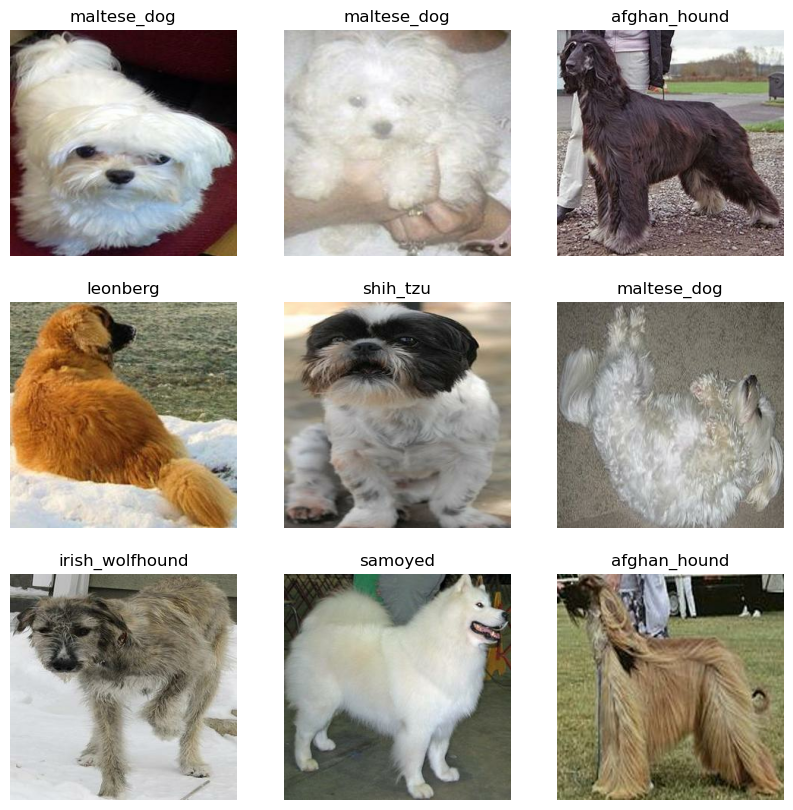

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype('uint8'))
        plt.title(names[list(labels[i]).index(1)])
        plt.axis('off')

## Pre-trained convolutional neural networks

In [19]:
model = Xception(weights='imagenet', input_shape=(img_size, img_size, 3))

In [20]:
path_to_image = 'data/processed/scottish_deerhound/n02092002_109.jpg'
img = load_img(path_to_image, target_size=image_size_tuple)
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)
decode_predictions(pred)

35363/35363 [==============================] - 0s 1us/step


[[('n02092002', 'Scottish_deerhound', 0.7939882),
  ('n02090721', 'Irish_wolfhound', 0.04308395),
  ('n02090622', 'borzoi', 0.005164045),
  ('n02091244', 'Ibizan_hound', 0.0030015495),
  ('n02100236', 'German_short-haired_pointer', 0.0029592111)]]

## Transfer learning

Using a small image size to decrease training time.

In [21]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False
inputs = keras.Input(shape=(img_size, img_size, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

83683744/83683744 [==============================] - 3s 0us/step


In [22]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [23]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
56/56 [==============================] - 183s 3s/step - loss: 46.3050 - accuracy: 0.2440 - val_loss: 20.1183 - val_accuracy: 0.3341
Epoch 2/10
56/56 [==============================] - 179s 3s/step - loss: 11.9096 - accuracy: 0.3895 - val_loss: 13.6010 - val_accuracy: 0.3565
Epoch 3/10
56/56 [==============================] - 178s 3s/step - loss: 14.6542 - accuracy: 0.3660 - val_loss: 14.2919 - val_accuracy: 0.3857
Epoch 4/10
56/56 [==============================] - 179s 3s/step - loss: 10.7209 - accuracy: 0.4734 - val_loss: 18.3239 - val_accuracy: 0.3857
Epoch 5/10
56/56 [==============================] - 179s 3s/step - loss: 9.7974 - accuracy: 0.4706 - val_loss: 11.9152 - val_accuracy: 0.3946
Epoch 6/10
56/56 [==============================] - 178s 3s/step - loss: 8.7790 - accuracy: 0.5260 - val_loss: 10.3128 - val_accuracy: 0.4260
Epoch 7/10
56/56 [==============================] - 178s 3s/step - loss: 9.8362 - accuracy: 0.5120 - val_loss: 12.9117 - val_accuracy: 0.4283
Ep

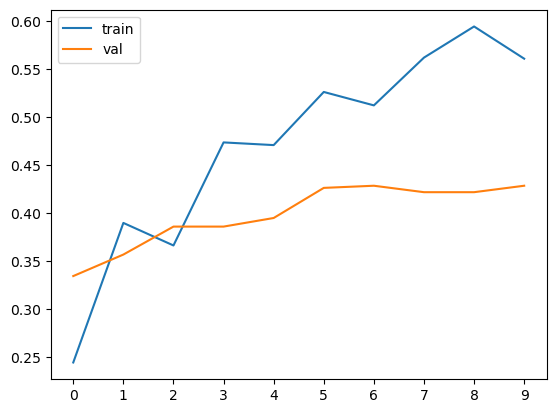

In [24]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()